# Evaluating results of main experiment

Here we process the results of the experiments encoded in `main_experiment.py` and `run_main_experiment.py`.  Regarding how to effectively process results managed by mlflow, we referred to [some handy coding examples](https://gist.github.com/DavidWalz/0f5e84ffc4c3929f3af5a93268eaeab9).

In [1]:
# External modules.
from matplotlib import colormaps
from matplotlib.cm import ScalarMappable
from matplotlib.colors import BoundaryNorm
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import os

# Internal modules.
from setup.directories import img_path
from setup.results import my_ext
from setup.utils import makedir_safe

In [2]:
# Make a directory to store images, if one doesn't exist already.
makedir_safe(img_path)

In [3]:
# For reference, specify the severity distribution (just for in-figure text).
severity_dist = "Poisson" # choose from ["uniform", "Poisson", "reverse Poisson"]
model_used = "CNN" # choose from ["CNN", "WRN"]

In [4]:
# Specify an experiment name, get relevant information.
exp_name = "exp:cifar10-sharpdro" # exp:[dataset_name], with dataset_name from dataset_names in run_main_experiment.py
data_name = exp_name.split(":")[1]
experiment = mlflow.get_experiment_by_name(name=exp_name)
print("Experiment_id: {}".format(experiment.experiment_id))
print("Artifact Location: {}".format(experiment.artifact_location))
print("Tags: {}".format(experiment.tags))
print("Lifecycle_stage: {}".format(experiment.lifecycle_stage))
print("Creation timestamp: {}".format(experiment.creation_time))
exp_id = experiment.experiment_id

Experiment_id: 273374809159371866
Artifact Location: file:///home/mjh/Dropbox/research/code/dev/addro-dev/addro/mlruns/273374809159371866
Tags: {}
Lifecycle_stage: active
Creation timestamp: 1717557643904


In [5]:
# Take a look at the "runs" associated with the selected experiment.
runs = mlflow.search_runs(exp_id)
runs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Columns: 124 entries, run_id to tags.mlflow.source.name
dtypes: datetime64[ns, UTC](2), float64(61), object(61)
memory usage: 126.1+ KB


Note that looking at `runs` associated with the current `exp_id`, we have a pandas dataframe, with entries organized according to both `RangeIndex` and `Columns`. The former essentially is a row corresponding to a single run. The latter corresponds to the various items we are storing.

In [6]:
# Look at all runs with a non-null setting (basically any param is fine).
runs_notnull = runs[runs["params.bs_tr"].notnull()]
runs_notnull.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129 entries, 0 to 128
Columns: 124 entries, run_id to tags.mlflow.source.name
dtypes: datetime64[ns, UTC](2), float64(61), object(61)
memory usage: 126.0+ KB


Moving forward, we would like to parse the `tags.mlflow.runName` column, splitting it into several columns that makes it much easier to index things.

In [7]:
# First, let's make a copy of the whole data frame to be safe.
runs_notnull_parsed = runs_notnull.copy()

# Next, grab the column to be parsed, populate some lists, turn into Series objects.
mth_family_names = []
mth_numbers = []
trial_numbers = []
for run_name in runs_notnull_parsed["tags.mlflow.runName"]:
    pc_check, mth_details = run_name.split(":")
    if pc_check == "parent":
        raise ValueError("Something is wrong; should not have any parent runs here.")
    elif pc_check == "child":
        mth_family_name, mth_number, trial_info = mth_details.split("-")
        mth_family_names += [mth_family_name]
        mth_numbers += [int(mth_number)]
        trial_numbers += [int(trial_info[1:])]
    else:
        raise ValueError("Something is wrong; did not find a child run.")

# Try adding these columns to the right-most side of the DataFrame of interest.
original_width = runs_notnull_parsed.shape[1]
runs_notnull_parsed.insert(original_width, "trial_number", trial_numbers)
runs_notnull_parsed.insert(original_width, "mth_number", mth_numbers)
runs_notnull_parsed.insert(original_width, "mth_family", mth_family_names)
runs_notnull_parsed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129 entries, 0 to 128
Columns: 127 entries, run_id to trial_number
dtypes: datetime64[ns, UTC](2), float64(61), int64(2), object(62)
memory usage: 129.0+ KB


Good, that was extremely easy. Before getting into some proper analysis, let's do some basic sanity checks.

In [8]:
# Check family names.
runs_tocheck = runs_notnull_parsed
print("== Unique trial numbers: ==")
unique_trial_numbers = np.sort(runs_notnull_parsed["trial_number"].unique())
print(unique_trial_numbers)
print("== Unique family names: ==")
unique_family_names = np.sort(runs_notnull_parsed["mth_family"].unique())
print(unique_family_names)
# Check method numbers.
for mth_family_name in unique_family_names:
    idx_methods = runs_tocheck["mth_family"] == mth_family_name
    runs_tocheck_methods = runs_tocheck[idx_methods]
    print("== Method number counts ({}): ==".format(mth_family_name))
    print(runs_tocheck_methods["mth_number"].value_counts())

== Unique trial numbers: ==
[0 1 2]
== Unique family names: ==
['AutoFloodedCVaR' 'AutoSoftFloodedCVaR' 'ERM' 'FloodedCVaR' 'FloodedDRO'
 'SharpDRO' 'SoftFloodedCVaR' 'SoftFloodedDRO']
== Method number counts (AutoFloodedCVaR): ==
mth_number
5    3
4    3
3    3
2    3
1    3
0    3
Name: count, dtype: int64
== Method number counts (AutoSoftFloodedCVaR): ==
mth_number
5    3
4    3
3    3
2    3
1    3
0    3
Name: count, dtype: int64
== Method number counts (ERM): ==
mth_number
0    3
Name: count, dtype: int64
== Method number counts (FloodedCVaR): ==
mth_number
5    3
4    3
3    3
2    3
1    3
0    3
Name: count, dtype: int64
== Method number counts (FloodedDRO): ==
mth_number
5    3
4    3
3    3
2    3
1    3
0    3
Name: count, dtype: int64
== Method number counts (SharpDRO): ==
mth_number
5    3
4    3
3    3
2    3
1    3
0    3
Name: count, dtype: int64
== Method number counts (SoftFloodedCVaR): ==
mth_number
5    3
4    3
3    3
2    3
1    3
0    3
Name: count, dtype: int64

Excellent, the sanity checks come out with the results that we expect. We are going to have need for metrics soon, so let's be sure to grab the metric names now.

In [9]:
# Metric names.
metrics = [c[8:] for c in runs_notnull_parsed.columns if c.startswith("metrics")]
metrics.sort()
print("== All metric names: ==")
print(metrics)

== All metric names: ==
['abc_0_te', 'abc_0_tr', 'abc_0_va', 'abc_1_te', 'abc_1_tr', 'abc_1_va', 'abc_2_te', 'abc_2_tr', 'abc_2_va', 'abc_3_te', 'abc_3_tr', 'abc_3_va', 'abc_4_te', 'abc_4_tr', 'abc_4_va', 'abc_5_te', 'abc_5_tr', 'abc_5_va', 'abc_6_te', 'abc_6_tr', 'abc_6_va', 'abc_7_te', 'abc_7_tr', 'abc_7_va', 'abc_8_te', 'abc_8_tr', 'abc_8_va', 'abc_9_te', 'abc_9_tr', 'abc_9_va', 'abs_0_te', 'abs_1_te', 'abs_2_te', 'abs_3_te', 'abs_4_te', 'abs_5_te', 'acc_te', 'acc_tr', 'acc_va', 'lbs_0_te', 'lbs_0_tr', 'lbs_0_va', 'lbs_1_te', 'lbs_1_tr', 'lbs_1_va', 'lbs_2_te', 'lbs_2_tr', 'lbs_2_va', 'lbs_3_te', 'lbs_3_tr', 'lbs_3_va', 'lbs_4_te', 'lbs_4_tr', 'lbs_4_va', 'lbs_5_te', 'lbs_5_tr', 'lbs_5_va', 'loss_te', 'loss_tr', 'loss_va', 'model_norm']


In [10]:
# Specify the metric to be used for validation.
metric_for_validation = "acc_va" #"loss_va" #"acc_va"
if metric_for_validation not in metrics:
    raise ValueError("The selected metric {} is not available.".format(metric_for_validation))
metric_type = metric_for_validation.split("_")[0]
data_type = metric_for_validation.split("_")[-1]
if metric_type == "loss" and data_type == "va":
    do_argmax = False
elif metric_type == "acc" and data_type == "va":
    do_argmax = True
else:
    raise ValueError("Unexpected metric for validation.")

# Function in charge of selecting the best candidate.
def get_best_idx(metric_history_list, do_argmax=do_argmax):
    '''
    Given a list of sequences, this function returns the index
    of the "best" sequence by taking an *argmax/min* over the *final* values
    of these sequences (e.g., final accuracy, loss, etc.).
    '''
    list_len = len(metric_history_list)
    if list_len < 1:
        raise ValueError("No metric histories provided.")
    elif list_len == 1:
        return 0
    else:
        values_to_compare = []
        for mh in metric_history_list:
            values_to_compare += [mh[-1]] # use last step.
        if do_argmax:
            return np.argmax(np.array(values_to_compare)).item()
        else:
            return np.argmin(np.array(values_to_compare)).item()

To proceed, we set up a loop very similar to the one we just did for our sanity checks, but this time we grab *candidate run IDs*, use these to read in the *metric history*, and then finally choose a *representative run ID* for each combination of (trial, method family).

In [11]:
# Set up a dictionary where we can store "representative" run IDs and results for each method family.
dict_of_run_ids = {m:[] for m in unique_family_names}

# Get the loop going, with a "client" for reading in metric history.
client = mlflow.tracking.MlflowClient()
runs_tocheck = runs_notnull_parsed
unique_trial_numbers = np.sort(runs_notnull_parsed["trial_number"].unique())
unique_family_names = np.sort(runs_notnull_parsed["mth_family"].unique())
for trial_number in unique_trial_numbers:
    runs_tocheck_bytrial = runs_tocheck[runs_tocheck["trial_number"] == trial_number]
    for mth_family_name in unique_family_names:
        idx_candidates = runs_tocheck_bytrial["mth_family"] == mth_family_name
        runs_tocheck_byfamily = runs_tocheck_bytrial[idx_candidates]
        candidate_run_ids = runs_tocheck_byfamily.run_id
        #print(type(candidate_run_ids), len(candidate_run_ids))
        #print(candidate_run_ids)
        if len(candidate_run_ids) == 1:
            # If only one setting, no need to check validation data.
            best_idx = 0
        elif len(candidate_run_ids) > 1:
            # When have multiple settings, use the specified metric for validation.
            metric_history_list = [
                [s.value for s in client.get_metric_history(r, metric_for_validation)] for r in candidate_run_ids
            ]
            best_idx = get_best_idx(metric_history_list)
        else:
            raise ValueError("No candidate runs...!")
            
        dict_of_run_ids[mth_family_name] += [candidate_run_ids.iloc[best_idx]]
                
print(dict_of_run_ids)

{'AutoFloodedCVaR': ['a021cd68611e4683845f3cdbf824461b', '1dd73baafad74894b8b13d658bedd813', '1ad84304e2ac4a7f9c993c6b7b6e7a63'], 'AutoSoftFloodedCVaR': ['adc408ef2ef2487d977efbea06764a41', '8880a1176263486f92a5a597fe5ba944', '638312b3f87c4a5eaa77c7aad424b5af'], 'ERM': ['ffd6a3a7f10a4f33b83720723f9d8e6d', 'fc516d7ffce34b2d8d1c8cfd23c205e5', 'f14e6575f2004f4086f647818ef30e81'], 'FloodedCVaR': ['b745ff1e690745bab9394bd9166d7d44', '9311de6a1d2941709148831c5479f07c', 'eedd0100b1fa46c484a6fc7574548b22'], 'FloodedDRO': ['dc4fa500380943e49ffc4595bd74f9ce', '7f5408744869495ba32c64e47a5b906a', '34d9d6bb6d984f2c83de9c196461fe63'], 'SharpDRO': ['5713a104b32d4206a5c02439a962eb40', 'be293d3004c444f9ac1f70af1deb6d92', 'a7164179afa4405ca16c1e7c0cc39e83'], 'SoftFloodedCVaR': ['a85921e2f20648639cc9f2bff0055809', '9f5a186947534dfbadaa5112277f9419', '3d0215aaa75c4cdfaeb350f47f4a7c94'], 'SoftFloodedDRO': ['82b82ba0a8cd4a7cb0d3945354618ed4', '5dc4a100e75a41c5bf655da22dc76f0c', 'ea918368c4894a22b21ec3edb73e

With all the final candidate run IDs in place, all that remains is to get the relevant metric histories for each, and plot them in a clear, readable fashion.

(AutoFloodedCVaR, params.flood_level)
mean: 0.041666666666666664 stdev: 0.014433756729740645
120     0.05
122     0.05
124    0.025
Name: params.flood_level, dtype: object
(AutoSoftFloodedCVaR, params.softad_level)
mean: 0.4000000000000001 stdev: 6.798699777552591e-17
57    0.4
58    0.4
59    0.4
Name: params.softad_level, dtype: object
(FloodedCVaR, params.flood_level)
mean: 0.09166666666666667 stdev: 0.09464847243000457
42      0.2
49     0.05
53    0.025
Name: params.flood_level, dtype: object
(FloodedDRO, params.flood_level)
mean: 0.23333333333333336 stdev: 0.1527525231651947
22    0.4
26    0.2
27    0.1
Name: params.flood_level, dtype: object
(SharpDRO, params.radius)
mean: 0.02916666666666667 stdev: 0.019094065395649337
12      0.05
16     0.025
20    0.0125
Name: params.radius, dtype: object
(SoftFloodedCVaR, params.softad_level)
mean: 0.2708333333333333 stdev: 0.22372322931098
93        0.4
94        0.4
110    0.0125
Name: params.softad_level, dtype: object
(SoftFloodedDRO, 

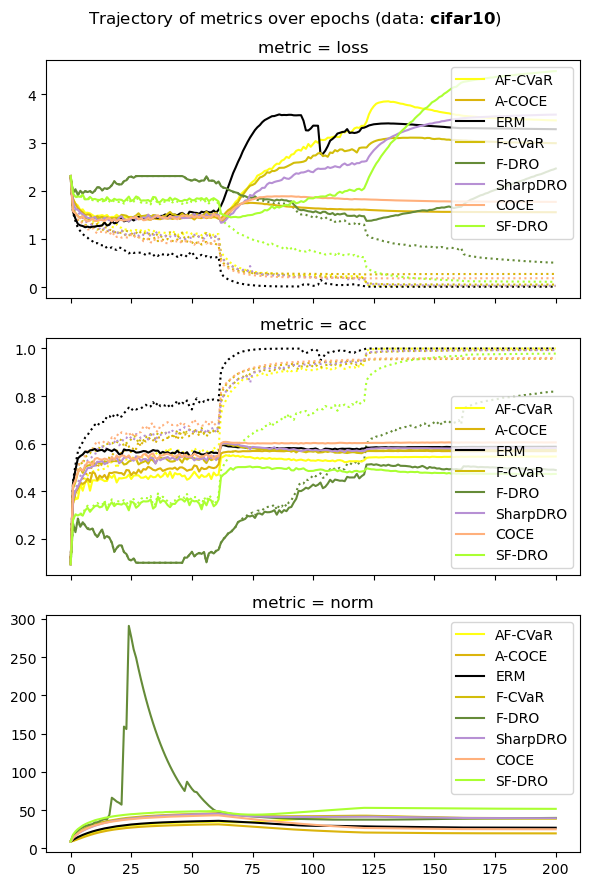

In [12]:
# List of metrics to use for each subplot.
metrics_to_use_list = [["loss_tr", "loss_te"], ["acc_tr", "acc_te"], ["model_norm"]]

# Color setup.
colors_by_method = {
    "AutoFloodedCVaR": "xkcd:yellow",
    "AutoSoftFloodedCVaR": "xkcd:gold",
    "SoftFloodedCVaR": "xkcd:peach",
    "SoftFloodedDRO": "xkcd:lime",
    "FloodedCVaR": "xkcd:mustard yellow",
    "FloodedDRO": "xkcd:moss green",
    "SharpDRO": "xkcd:pale purple",
    "ERM": "xkcd:black",
    "Ishida": "xkcd:aquamarine",
    "SAM": "xkcd:neon purple",
    "SoftAD": "xkcd:pinkish red",
    "Tilted": "xkcd:green"
}

# Name setup.
plotnames_by_method = {
    "AutoFloodedCVaR": "AF-CVaR",
    "AutoSoftFloodedCVaR": "A-COCE",
    "SoftFloodedCVaR": "COCE",
    "SoftFloodedDRO": "SF-DRO",
    "FloodedCVaR": "F-CVaR",
    "FloodedDRO": "F-DRO",
    "SharpDRO": "SharpDRO",
    "ERM": "ERM",
    "Ishida": "Flood",
    "SAM": "SAM",
    "SoftAD": "SoftAD",
    "Tilted": "Tilted"
}

# Extra details to check.
extras_by_method = {
    "AutoFloodedCVaR": ["params.flood_level"],
    "AutoSoftFloodedCVaR": ["params.softad_level"],
    "SoftFloodedCVaR": ["params.softad_level"],
    "SoftFloodedDRO": ["params.softad_level"],
    "FloodedCVaR": ["params.flood_level"],
    "FloodedDRO": ["params.flood_level"],
    "SharpDRO": ["params.radius"],
    "ERM": [],
    "Ishida": ["params.flood_level"],
    "SAM": ["params.radius"],
    "SoftAD": ["params.theta"],
    "Tilted": ["params.tilt"]
}


client = mlflow.tracking.MlflowClient()
# Prepare the figure (one sub-plot per metric, but with tr and te on same plot).
fig, axes = plt.subplots(3, figsize=(6, 3*len(metrics_to_use_list)), sharex=True)

# Get the run IDs selected for all methods at this noise level.
best_run_ids = dict_of_run_ids

# For each method, look at extra info of interest.
for mth_family_name in best_run_ids:
    extras_list = extras_by_method[mth_family_name]
    if len(extras_list) > 0:
        df = runs_notnull_parsed[runs_notnull_parsed["run_id"].isin(best_run_ids[mth_family_name])]
        for extra_name in extras_list:
            print("({}, {})".format(mth_family_name, extra_name))
            print("mean:", df[extra_name].astype(float).mean(),
                  "stdev:", df[extra_name].astype(float).std())
            print(df[extra_name])

# Get a loop going.
for ax, metrics_to_use in zip(axes, metrics_to_use_list):

    # Process things for the first metric (always at least one).
    metric_to_use = metrics_to_use[0] # set metric name by hand.
    print("final values (ave, {})".format(metric_to_use))
    for mth_family_name in best_run_ids:
        # Get metrics for the representative candidates.
        metric_array = [
            [s.value for s in client.get_metric_history(r, metric_to_use)] for r in best_run_ids[mth_family_name]
        ]
        # Organize into a numpy array, and plot the average over trials.
        metric_array = np.array(metric_array)
        #print("DBDB", mth_family_name, metric_to_use, metric_array.shape)
        
        if metrics_to_use[0] == "model_norm":
            linestyle_to_use = "solid"
            label_to_use = plotnames_by_method[mth_family_name]
        else:
            linestyle_to_use = "dotted"
            label_to_use = None
        ax.plot(
            np.arange(0, metric_array.shape[1], 1), metric_array.mean(axis=0),
            color=colors_by_method[mth_family_name],
            linestyle=linestyle_to_use,
            label=label_to_use
        )
        print(" ", metric_array.mean(axis=0)[-1], "({})".format(mth_family_name))

    # If have more than one metric, plot the second one, but no more.
    if len(metrics_to_use) > 1:
        metric_to_use = metrics_to_use[1] # set metric name by hand.
        print("final values (ave, {})".format(metric_to_use))
        for mth_family_name in best_run_ids:
            # Get metrics for the representative candidates.
            metric_array = [
                [s.value for s in client.get_metric_history(r, metric_to_use)] for r in best_run_ids[mth_family_name]
            ]
            # Organize into a numpy array, and plot the average over trials.
            metric_array = np.array(metric_array)
            label_to_use = plotnames_by_method[mth_family_name]
            ax.plot(
                np.arange(0, metric_array.shape[1], 1), metric_array.mean(axis=0),
                color=colors_by_method[mth_family_name],
                linestyle="solid",
                label=label_to_use
            )
            print(" ", metric_array.mean(axis=0)[-1], "({})".format(mth_family_name))
    if len(metrics_to_use) > 2:
        raise ValueError("Expected one or two metrics, no more/less.")

    if metrics_to_use[0] == "loss_tr" and data_name == "svhn":
        ax.set(ylim=(-0.05, 1.5))

    # Having plotted for all methods, configure other parts of the current sub-plot.
    metric_name_for_plot = metrics_to_use[0].split("_")[0 if len(metrics_to_use) > 1 else 1]
    ax.set_title("metric = {}".format(metric_name_for_plot))
    ax.legend(loc="best")
    
# Finally, macroscropic settings for the whole figure.
original_data_name = data_name.split("-")[0]
fig.suptitle(
    "Trajectory of metrics over epochs " + r"(data: $\mathbf{"+str(original_data_name)+"}$)"
)
plt.tight_layout()
fname = os.path.join(img_path, "mainexp_{}.{}".format(data_name, my_ext))
plt.savefig(fname=fname)
plt.show()

final values (ave, loss_tr)
  0.27387643853823346 (AutoSoftFloodedCVaR)
  0.009577147973080477 (ERM)
  0.0287900244196256 (SharpDRO)
  0.184731292227904 (SoftFloodedCVaR)
final values (ave, loss_te)
  1.5540674130121868 (AutoSoftFloodedCVaR)
  3.276266098022461 (ERM)
  3.5789390405019126 (SharpDRO)
  1.7683666547139485 (SoftFloodedCVaR)


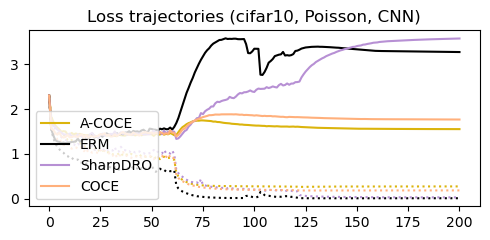

In [13]:
# This is just a compact version of the previous cell for use in papers.

# List of metrics to use for each subplot.
metrics_to_use = ["loss_tr", "loss_te"]

# List of methods to evaluate.
family_names_compact = ["AutoSoftFloodedCVaR", "ERM", "SharpDRO", "SoftFloodedCVaR"]

client = mlflow.tracking.MlflowClient()
# Prepare the figure (tr and te on same plot).
fig, ax = plt.subplots(1, figsize=(5, 2.5))

# Get the run IDs selected for all methods at this noise level.
best_run_ids = dict_of_run_ids

# Process things for the first metric (always at least one).
metric_to_use = metrics_to_use[0] # set metric name by hand.
print("final values (ave, {})".format(metric_to_use))
for mth_family_name in family_names_compact:
    # Get metrics for the representative candidates.
    metric_array = [
        [s.value for s in client.get_metric_history(r, metric_to_use)] for r in best_run_ids[mth_family_name]
    ]
    # Organize into a numpy array, and plot the average over trials.
    metric_array = np.array(metric_array)
    #print("DBDB", mth_family_name, metric_to_use, metric_array.shape)
        
    if metrics_to_use[0] == "model_norm":
        linestyle_to_use = "solid"
        label_to_use = plotnames_by_method[mth_family_name]
    else:
        linestyle_to_use = "dotted"
        label_to_use = None
    ax.plot(
        np.arange(0, metric_array.shape[1], 1), metric_array.mean(axis=0),
        color=colors_by_method[mth_family_name],
        linestyle=linestyle_to_use,
        label=label_to_use
    )
    print(" ", metric_array.mean(axis=0)[-1], "({})".format(mth_family_name))

# If have more than one metric, plot the second one, but no more.
if len(metrics_to_use) > 1:
    metric_to_use = metrics_to_use[1] # set metric name by hand.
    print("final values (ave, {})".format(metric_to_use))
    for mth_family_name in family_names_compact:
        # Get metrics for the representative candidates.
        metric_array = [
            [s.value for s in client.get_metric_history(r, metric_to_use)] for r in best_run_ids[mth_family_name]
        ]
        # Organize into a numpy array, and plot the average over trials.
        metric_array = np.array(metric_array)
        label_to_use = plotnames_by_method[mth_family_name]
        ax.plot(
            np.arange(0, metric_array.shape[1], 1), metric_array.mean(axis=0),
            color=colors_by_method[mth_family_name],
            linestyle="solid",
            label=label_to_use
        )
        print(" ", metric_array.mean(axis=0)[-1], "({})".format(mth_family_name))
if len(metrics_to_use) > 2:
    raise ValueError("Expected one or two metrics, no more/less.")

#if metrics_to_use[0] == "loss_tr":
#    ax.set(ylim=(-0.1, 5.0))
original_data_name = data_name.split("-")[0]
ax.set_title("Loss trajectories ({}, {}, {})".format(original_data_name, severity_dist, model_used))
ax.legend(loc="lower left")
plt.tight_layout()
fname = os.path.join(img_path, "mainexp_compact_{}.{}".format(data_name, my_ext))
plt.savefig(fname=fname)
plt.show()

Next we follow this up with a simple visualization of per-class accuracies, for now using the same choice of "best" run as in the immediately preceding cell.

All clear. Number of classes: 10


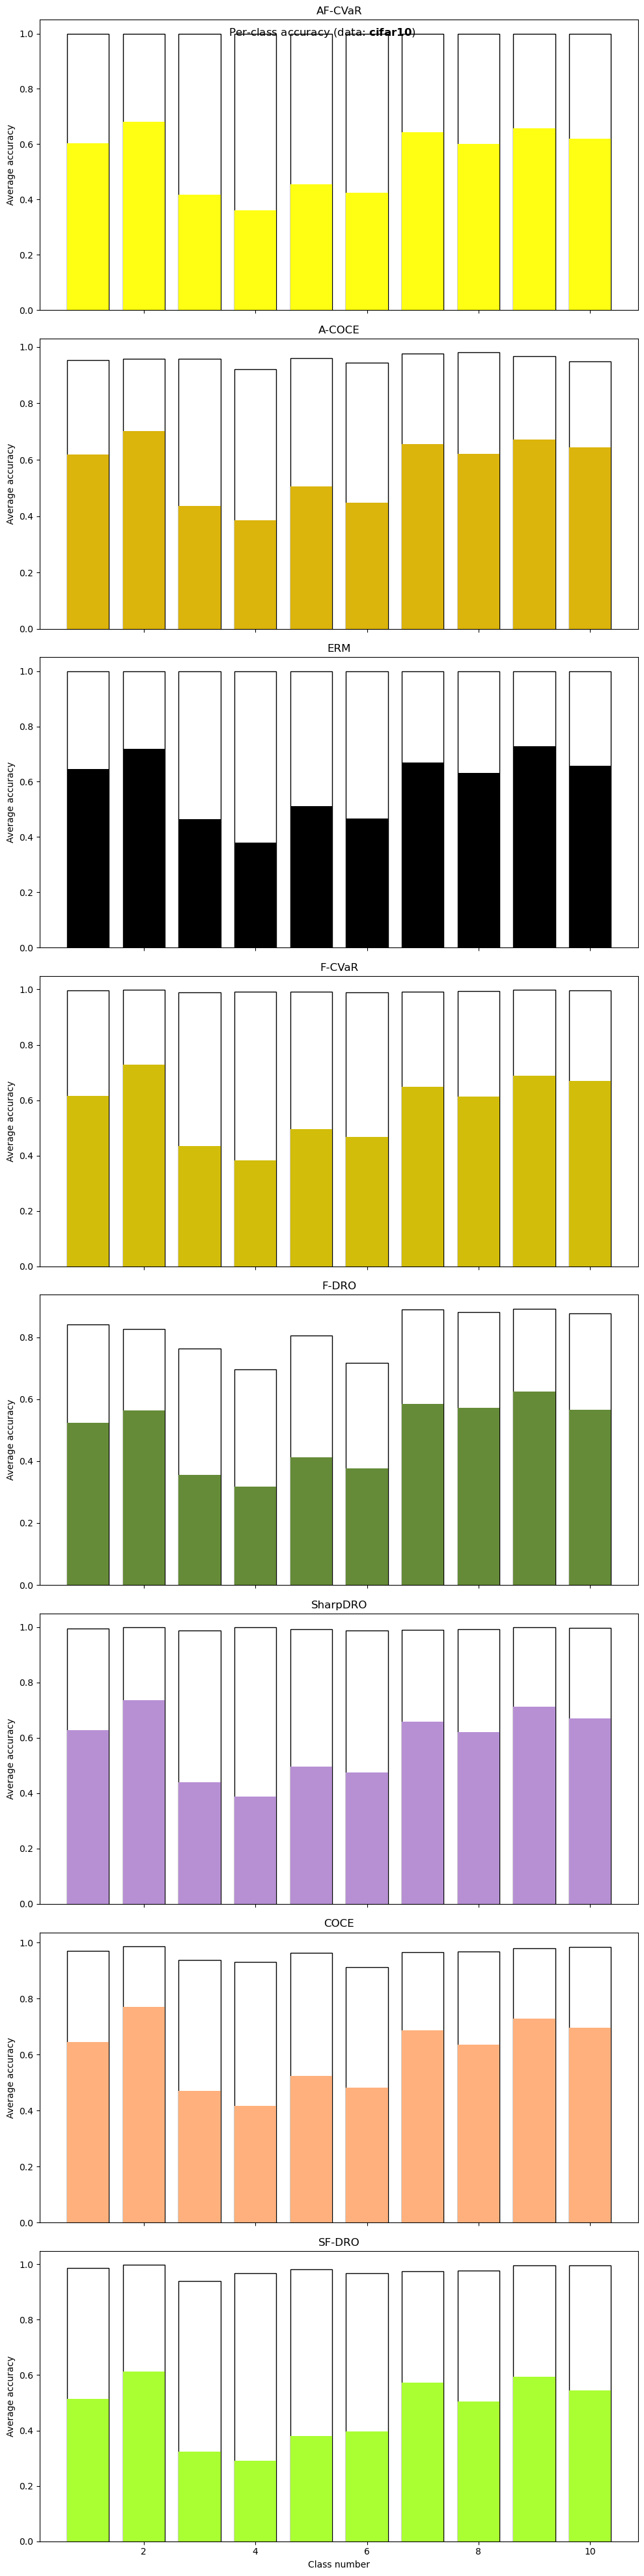

In [14]:
# Get all the "accuracy by class (abc)" metric names.
metrics_abc_tr = []
metrics_abc_te = []
for m in metrics:
    if m[0:3] == "abc":
        if m[-2:] == "tr":
            metrics_abc_tr += [m]
        elif m[-2:] == "te":
            metrics_abc_te += [m]
        else:
            continue
if len(metrics_abc_tr) == len(metrics_abc_te):
    num_classes = len(metrics_abc_tr)
    print("All clear. Number of classes:", num_classes)
else:
    raise ValueError("Something wrong, metrics_abc_* has different length between tr/te.")
metrics_abc_tr = [] # re-build in sorted order.
metrics_abc_te = [] # re-build in sorted order.
for i in range(num_classes):
    metrics_abc_tr += ["abc_{}_tr".format(i)]
    metrics_abc_te += ["abc_{}_te".format(i)]
#print("tr:")
#print(metrics_abc_tr)
#print("te:")
#print(metrics_abc_te)

# Get the run IDs selected for all methods.
best_run_ids = dict_of_run_ids

# Prepare the figure (one sub-plot per method, but with tr and te on same plot).
fig, axes = plt.subplots(len(best_run_ids), figsize=(10, 5*len(best_run_ids)), sharex=True)

# Get tracking going.
client = mlflow.tracking.MlflowClient()

# Get the outer loop over methods going.
for i, mth_family_name in enumerate(best_run_ids):
    
    if len(best_run_ids) == 1:
        ax = axes
    else:
        ax = axes[i]
    
    bar_lengths_tr = []
    bar_lengths_te = []

    # Get inner loop over metrics going.
    for m_tr, m_te in zip(metrics_abc_tr, metrics_abc_te):
        
        # Get metrics for the representative candidates.
        metric_array_tr = [
            [s.value for s in client.get_metric_history(r, m_tr)] for r in best_run_ids[mth_family_name]
        ]
        metric_array_te = [
            [s.value for s in client.get_metric_history(r, m_te)] for r in best_run_ids[mth_family_name]
        ]
        # Organize into a numpy array.
        metric_array_tr = np.array(metric_array_tr)
        metric_array_te = np.array(metric_array_te)
        #print("DBDB", mth_family_name, m_tr, metric_array_tr.shape, m_te, metric_array_te.shape)

        # Average over trials (ignoring NaN values) and take value after final epoch.
        bar_lengths_tr += [np.nanmean(metric_array_tr, axis=0)[-1]] # note we use nanmean()
        bar_lengths_te += [np.nanmean(metric_array_te, axis=0)[-1]] # note we use nanmean()

    # Now that bar contents are ready, plot them in a visually pleasing manner.
    bar_numbers = np.array([j+1 for j in range(num_classes)])
    bar_width = 0.75
    rects_tr = ax.bar(bar_numbers, bar_lengths_tr, bar_width,
                      fill=False, color=colors_by_method[mth_family_name])
    rects_te = ax.bar(bar_numbers, bar_lengths_te, bar_width,
                      color=colors_by_method[mth_family_name])
    if i+1 == len(best_run_ids):
        ax.set_xlabel("Class number")
    ax.set_title("{}".format(plotnames_by_method[mth_family_name]))
    ax.set_ylabel("Average accuracy")
    

# Finally, macroscropic settings for the whole figure.
original_data_name = data_name.split("-")[0]
fig.suptitle(
    "Per-class accuracy " + r"(data: $\mathbf{"+str(original_data_name)+"}$)"
)
plt.tight_layout()
fname = os.path.join(img_path, "mainexp_accbyclass_{}.{}".format(data_name, my_ext))
plt.savefig(fname=fname)
plt.show()

In a totally analogous fashion, we grab per-severity test accuracies, for now using the same choice of "best" run as in the immediately preceding cells.

In [15]:
# Get all the "accuracy by severity (abs)" metric names.
metrics_abs_te = []
for m in metrics:
    if m[0:3] == "abs":
        metrics_abs_te += [m]
    else:
        continue
print("== Number of severity levels (including clean) found: ==")
num_distributions = len(metrics_abs_te)
print(num_distributions)

metrics_abs_te = [] # re-build in sorted order.
for i in range(num_distributions):
    metrics_abs_te += ["abs_{}_te".format(i)]
#print("tr:")
#print(metrics_abc_tr)
#print("te:")
#print(metrics_abc_te)

== Number of severity levels (including clean) found: ==
6


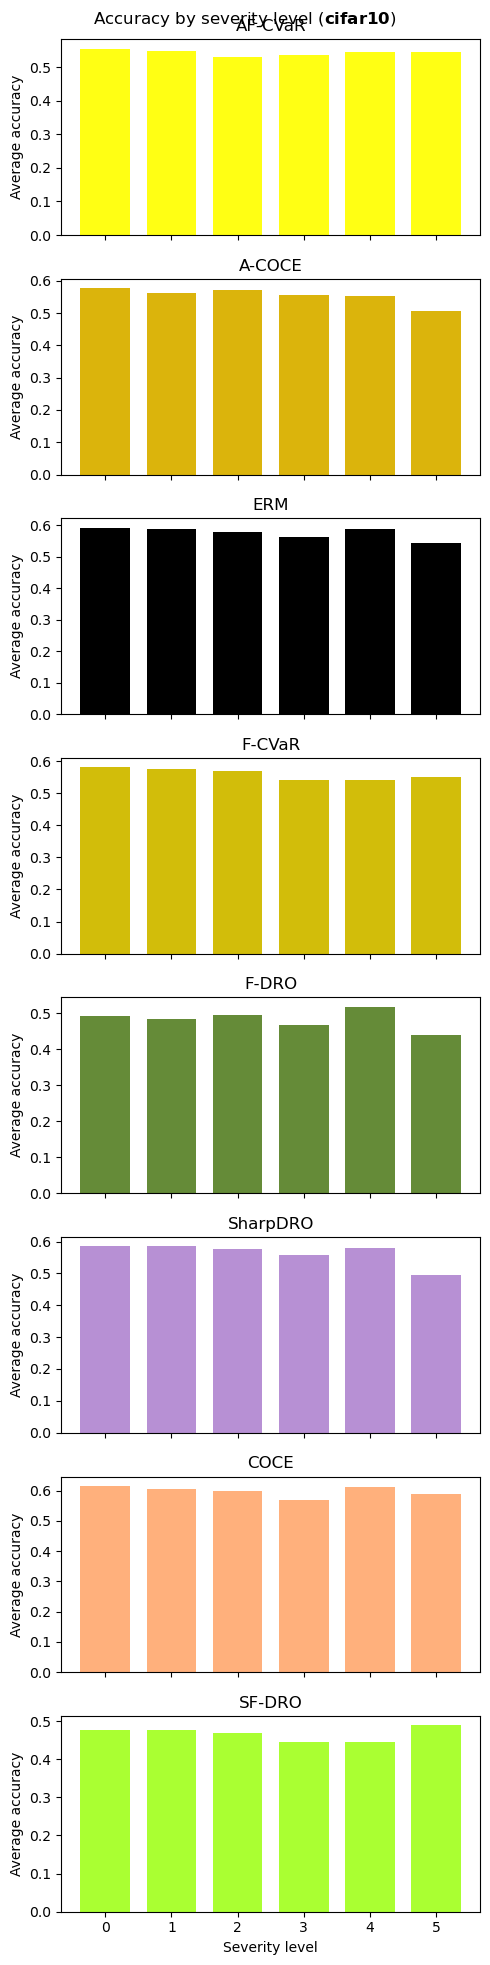

In [16]:
# Get the run IDs selected for all methods.
best_run_ids = dict_of_run_ids

# Prepare the figure (one sub-plot per method, but with tr and te on same plot).
fig, axes = plt.subplots(len(best_run_ids), figsize=(5, 2.5*len(best_run_ids)), sharex=True)

# Get tracking going.
client = mlflow.tracking.MlflowClient()

# Get the outer loop over methods going.
for i, mth_family_name in enumerate(best_run_ids):
    
    if len(best_run_ids) == 1:
        ax = axes
    else:
        ax = axes[i]
    
    bar_lengths_te = []

    # Get inner loop over metrics going.
    for m_te in metrics_abs_te:
        
        # Get metrics for the representative candidates.
        metric_array_te = [
            [s.value for s in client.get_metric_history(r, m_te)] for r in best_run_ids[mth_family_name]
        ]
        # Organize into a numpy array.
        metric_array_te = np.array(metric_array_te)
        #print(mth_family_name, m_tr, metric_array_tr.shape, m_te, metric_array_te.shape)

        # Average over trials (ignoring NaN values) and take value after final epoch.
        bar_lengths_te += [np.nanmean(metric_array_te, axis=0)[-1]] # note we use nanmean()

    # Now that bar contents are ready, plot them in a visually pleasing manner.
    bar_numbers = np.array([j for j in range(num_distributions)])
    bar_width = 0.75
    rects_te = ax.bar(bar_numbers, bar_lengths_te, bar_width,
                      color=colors_by_method[mth_family_name])
    if i+1 == len(best_run_ids):
        ax.set_xlabel("Severity level")
    ax.set_title("{}".format(plotnames_by_method[mth_family_name]))
    ax.set_ylabel("Average accuracy")

# Finally, macroscropic settings for the whole figure.
original_data_name = data_name.split("-")[0]
fig.suptitle(
    "Accuracy by severity level " + r"($\mathbf{"+original_data_name+"}$)"
)
plt.tight_layout()
fname = os.path.join(img_path, "mainexp_accbysev_{}.{}".format(data_name, my_ext))
plt.savefig(fname=fname)
plt.show()

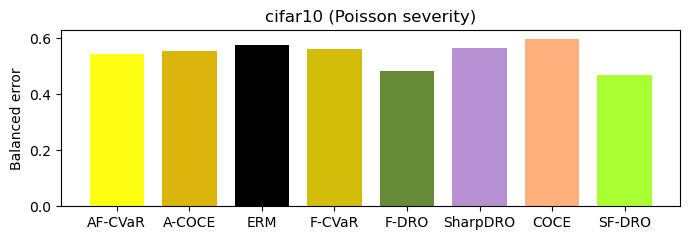

In [17]:
# Get the run IDs selected for all methods.
best_run_ids = dict_of_run_ids

# Prepare the figure (one sub-plot per method, but with tr and te on same plot).
fig, ax = plt.subplots(1, figsize=(7, 2.5))

# Get tracking going.
client = mlflow.tracking.MlflowClient()

# Get the outer loop over methods going.
bar_lengths_te = []
bar_colors = []
bar_labels = []
for i, mth_family_name in enumerate(best_run_ids):

    bar_colors += [colors_by_method[mth_family_name]]
    bar_labels += [plotnames_by_method[mth_family_name]]
    
    accs_by_severity = []

    # Get inner loop over metrics going.
    for m_te in metrics_abs_te:
        
        # Get metrics for the representative candidates.
        metric_array_te = [
            [s.value for s in client.get_metric_history(r, m_te)] for r in best_run_ids[mth_family_name]
        ]
        # Organize into a numpy array.
        metric_array_te = np.array(metric_array_te)
        #print(mth_family_name, m_tr, metric_array_tr.shape, m_te, metric_array_te.shape)

        # Average over trials (ignoring NaN values) and take value after final epoch.
        accs_by_severity += [np.nanmean(metric_array_te, axis=0)[-1]] # note we use nanmean()

    bar_lengths_te += [np.array(accs_by_severity).mean()] # balanced error.

# Now that bar contents are ready, plot them in a visually pleasing manner.
bar_width = 0.75
rects_te = ax.bar(bar_labels, bar_lengths_te, bar_width, color=bar_colors)
original_data_name = data_name.split("-")[0]
ax.set_title("{} ({} severity)".format(original_data_name, severity_dist))
ax.set_ylabel("Balanced error")

# Finally, macroscropic settings for the whole figure.
plt.tight_layout()
fname = os.path.join(img_path, "mainexp_balerr_{}.{}".format(data_name, my_ext))
plt.savefig(fname=fname)
plt.show()

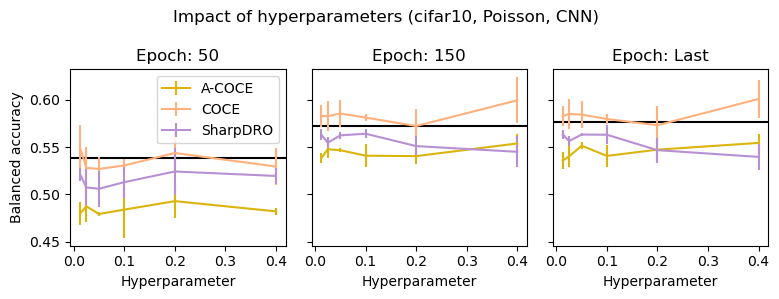

In [18]:
# Specify the methods to work on.
methods_todo = ["ERM", "AutoSoftFloodedCVaR", "SoftFloodedCVaR", "SharpDRO"]

# Color setup.
colors_by_method = {
    "AutoFloodedCVaR": "xkcd:yellow",
    "AutoSoftFloodedCVaR": "xkcd:gold",
    "SoftFloodedCVaR": "xkcd:peach",
    "SoftFloodedDRO": "xkcd:lime",
    "FloodedCVaR": "xkcd:mustard yellow",
    "FloodedDRO": "xkcd:moss green",
    "SharpDRO": "xkcd:pale purple",
    "ERM": "xkcd:black",
    "Ishida": "xkcd:aquamarine",
    "SAM": "xkcd:neon purple",
    "SoftAD": "xkcd:pinkish red",
    "Tilted": "xkcd:green"
}

# Name setup.
plotnames_by_method = {
    "AutoFloodedCVaR": "AF-CVaR",
    "AutoSoftFloodedCVaR": "A-COCE",
    "SoftFloodedCVaR": "COCE",
    "SoftFloodedDRO": "SF-DRO",
    "FloodedCVaR": "F-CVaR",
    "FloodedDRO": "F-DRO",
    "SharpDRO": "SharpDRO",
    "ERM": "ERM",
    "Ishida": "Flood",
    "SAM": "SAM",
    "SoftAD": "SoftAD",
    "Tilted": "Tilted"
}

# Extra details to check.
extras_by_method = {
    "AutoFloodedCVaR": ["params.flood_level"],
    "AutoSoftFloodedCVaR": ["params.softad_level"],
    "SoftFloodedCVaR": ["params.softad_level"],
    "SoftFloodedDRO": ["params.softad_level"],
    "FloodedCVaR": ["params.flood_level"],
    "FloodedDRO": ["params.flood_level"],
    "SharpDRO": ["params.radius"],
    "ERM": [],
    "Ishida": ["params.flood_level"],
    "SAM": ["params.radius"],
    "SoftAD": ["params.theta"],
    "Tilted": ["params.tilt"]
}

# Title setup.
title_metrics = {"acc_te": "test accuracy",
                 "loss_te": "test loss"}
ylabel_metrics = {"acc_te": "Accuracy",
                  "loss_te": "Average loss"}

# Prepare basic storage dictionary.
metric_storage_alltrials = { mth: [] for mth in methods_todo }
param_storage_alltrials = { mth: [] for mth in methods_todo }

# Get the loop going, with a "client" for reading in metric history.
client = mlflow.tracking.MlflowClient()
runs_tocheck = runs_notnull_parsed
unique_trial_numbers = np.sort(runs_notnull_parsed["trial_number"].unique())
for trial_number in unique_trial_numbers:
    metric_storage = { mth: [] for mth in methods_todo }
    param_storage = { mth: [] for mth in methods_todo }
    runs_tocheck_bytrial = runs_tocheck[runs_tocheck["trial_number"] == trial_number]
    for mth_family_name in methods_todo:
        idx_candidates = runs_tocheck_bytrial["mth_family"] == mth_family_name
        runs_tocheck_byfamily = runs_tocheck_bytrial[idx_candidates]
        candidate_run_ids = runs_tocheck_byfamily.run_id
        for run_id in candidate_run_ids:
            if len(candidate_run_ids) > 1:
                idx = runs_tocheck_byfamily["run_id"] == run_id
                param_value = float(runs_tocheck_byfamily[idx][extras_by_method[mth_family_name]].squeeze())
                #print(param_value, type(param_value))
                param_storage[mth_family_name] += [param_value]
                # Get inner loop over severity levels going.
                accs_by_severity = []
                for m_te in metrics_abs_te:
                    metric_array_te =  np.array([s.value for s in client.get_metric_history(run_id, m_te)])
                    accs_by_severity += [np.copy(metric_array_te)]
                # Compute the balanced error (average over all severities).
                metric_storage[mth_family_name] += [np.vstack(accs_by_severity).mean(axis=0)]
            else:
                # Get inner loop over severity levels going.
                accs_by_severity = []
                for m_te in metrics_abs_te:
                    metric_array_te =  np.array([s.value for s in client.get_metric_history(run_id, m_te)])
                    accs_by_severity += [np.copy(metric_array_te)]
                # Compute the balanced error (average over all severities).
                metric_storage[mth_family_name] += [np.vstack(accs_by_severity).mean(axis=0)]

    # Prepare ndarrays and store the info for this trial.
    for mth in metric_storage:
        metric_storage[mth] = np.expand_dims(np.vstack(metric_storage[mth]), 0)
        #print(mth, metric_storage[mth].shape)
        metric_storage_alltrials[mth] += [metric_storage[mth]]
        if mth != "ERM":
            param_storage[mth] = np.expand_dims(np.array(param_storage[mth]), 0)
            #print(param_storage[mth].shape)
            param_storage_alltrials[mth] += [param_storage[mth]]
        else:
            param_storage_alltrials[mth] = None

# After all trials are included, stack the arrays as needed.
for mth in metric_storage_alltrials:
    metric_storage_alltrials[mth] = np.vstack(metric_storage_alltrials[mth])
    #print(mth, metric_storage_alltrials[mth].shape)
    if mth != "ERM":
        param_storage_alltrials[mth] = np.vstack(param_storage_alltrials[mth])
    #print(param_storage_alltrials[mth].shape)

# Finally, let us visualize things.
epoch_indices = [50, 150, -1]
epoch_names = ["50", "150", "Last"]
fig, axes = plt.subplots(1, len(epoch_indices), figsize=(8,3), sharey=True)
title_metric = "balanced accuracy"
ylabel_metric = "Balanced accuracy"
for i, ax in enumerate(axes):
    epoch_idx = epoch_indices[i]
    epoch_name = epoch_names[i]
    for mth in metric_storage_alltrials:
        if mth != "ERM":
            toplot_hp = param_storage_alltrials[mth][0,...] # identical over all trials, so idx 0 is fine.
            sorted_idx = np.argsort(toplot_hp)
            toplot_hp = toplot_hp[sorted_idx]
            toplot_perf = np.mean(metric_storage_alltrials[mth][:,:,epoch_idx], axis=0)
            toplot_perf = toplot_perf[sorted_idx]
            toplot_err = np.std(metric_storage_alltrials[mth][:,:,epoch_idx], axis=0)
            toplot_err = toplot_err[sorted_idx]
            ax.errorbar(toplot_hp, toplot_perf, yerr=toplot_err, fmt="",
                        color=colors_by_method[mth],
                        linestyle="solid", label=plotnames_by_method[mth])
        else:
            toplot_perf = np.mean(metric_storage_alltrials[mth][:,:,epoch_idx], axis=0)
            ax.axhline(y=toplot_perf.item(), color=colors_by_method[mth])
            
    ax.set_title("Epoch: {}".format(epoch_name))
    ax.set_xlabel("Hyperparameter")
    if i == 0:
        ax.set_ylabel(ylabel_metric)
        ax.legend(loc="best")
original_data_name = data_name.split("-")[0]
fig.suptitle(
    "Impact of hyperparameters ({}, {}, {})".format(original_data_name, severity_dist, model_used)
)
plt.tight_layout()
fname = os.path.join(img_path, "mainexp_balerrhyp_{}.{}".format(data_name, my_ext))
plt.savefig(fname=fname)
plt.show()

___